# Submission Sanity Check

In [1]:
# Imports
import numpy as np
import pandas as pd
import random

from glob import glob
import pydicom

from PIL import Image

from matplotlib import pyplot as plt
import matplotlib

import os
print(os.listdir("../input"))

# Import rle utils
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')
from mask_functions import rle2mask, mask2rle # import mask utilities

['siim-acr-pneumothorax-segmentation', 'siim-train-test', 'pneumothorax-submission']


I am trying to build a model for the Pneumothorax Segmentation competition and to be honest I am not doing well. That is why I am trying to look at my submission files to get some insights of how I could improve the model.

You can also use the code below to analyze your submission or just to have fun.

## Load data

Load the csv with submission:

In [2]:
# Load submission file 
submission = pd.read_csv("../input/pneumothorax-submission/submission09.csv")
submission = submission.set_index('ImageId')

submission.head()

,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.5797.1517875190.762694,697527 14 1010 14 1010 14 1010 14 1010 14 1005...
1.2.276.0.7230010.3.1.4.8323329.5798.1517875190.796716,-1
1.2.276.0.7230010.3.1.4.8323329.5799.1517875190.806810,-1
1.2.276.0.7230010.3.1.4.8323329.580.1517875163.537053,-1
1.2.276.0.7230010.3.1.4.8323329.5800.1517875190.832691,-1


Load images from the test dataset:

In [3]:
# Load test data
datafilepath = '../input/siim-train-test/siim/'
fns = sorted(glob(datafilepath + 'dicom-images-test/*/*/*.dcm'))

## Plot single images

Following code helps to plot a single image and predicted mask:

In [4]:
# Function to plot single image with mask
def get_image_and_pred(idx, fns, submission):
    '''
    Function to plot single image with mask
    INPUT:
        idx - number of the image to plot
        fns - test data files
        submission - submission dataframe
        
    OUTPUT:
        has_pneumo - (True or False) whether the image has pneumothorax (according to the prediction)
        image - PIL image for the image from the test set
        rle_mask - rle mask of the mask predicted for thr image
        mask - PIL image for the predicted mask
    '''
    fname = fns[idx]
    
    dataset = pydicom.read_file(fname)
    np_image = np.expand_dims(dataset.pixel_array, axis=2)
    
    image = Image.fromarray(np_image.reshape(1024, 1024) , 'L')
    
    if '-1' in submission.loc[fname.split('/')[-1][:-4],'EncodedPixels']:
        np_mask = np.zeros((1024, 1024, 1), dtype=np.bool)
        rle_mask = None
        
        has_pneumo = False
    
    else:
        rle_mask = rle2mask(submission.loc[fname.split('/')[-1][:-4],'EncodedPixels'], 1024, 1024)
        
        if type(submission.loc[fname.split('/')[-1][:-4],'EncodedPixels']) == str:
            np_mask = np.expand_dims(rle2mask(submission.loc[fname.split('/')[-1][:-4],'EncodedPixels'], 1024, 1024), axis=2)
        else:
            np_mask = np.zeros((1024, 1024, 1))
            for x in submission.loc[fname.split('/')[-1][:-4],'EncodedPixels']:
                np_mask =  np_mask + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
                
        has_pneumo = True
    
    np_mask = np.transpose(np_mask)
    mask = Image.fromarray((np_mask * 255).reshape(1024, 1024) , 'L')
    
    return has_pneumo, image, rle_mask, mask

In [5]:
# get image and prediction
pneumo, image, rle_mask, mask = get_image_and_pred(0, fns, submission)

In [6]:
# Function to plot the prediction
def plot_xray(image, rle_mask):
    '''
    Function to plot a single prediction:
    INPUT:
        image - PIL image from the test dataset
        rle_mask - rle mask predicted for the image
    '''
    fig, axs = plt.subplots(1, 2, figsize=(20,10))

    #plot the original data
    axs[0].imshow(image, cmap='bone') 
    axs[0].axis('off')
    axs[0].set_title('Without mask')

    #plot image and add the mask
    axs[1].imshow(image, cmap='bone')
    axs[1].axis('off')  
    axs[1].imshow(rle_mask, alpha=0.3, cmap="Reds")    
    axs[1].set_title('With mask')

    # set suptitle
    plt.suptitle('Images with pneumothorax')
    plt.show()

Try to plot single predictions:

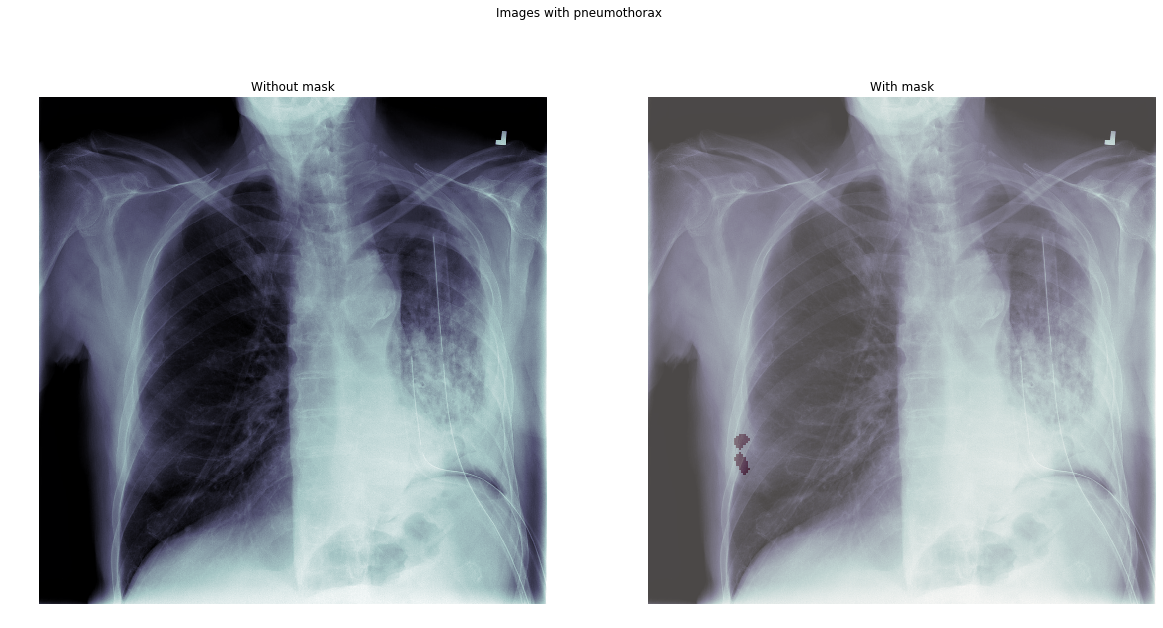

In [7]:
# try plotting the prediction
plot_xray(image, rle_mask)

This doesn't look so bad:
* Pneumothorax is a small area as it usually is.
* The model found pneumothorax near the edge of the lung, where I would look for it.

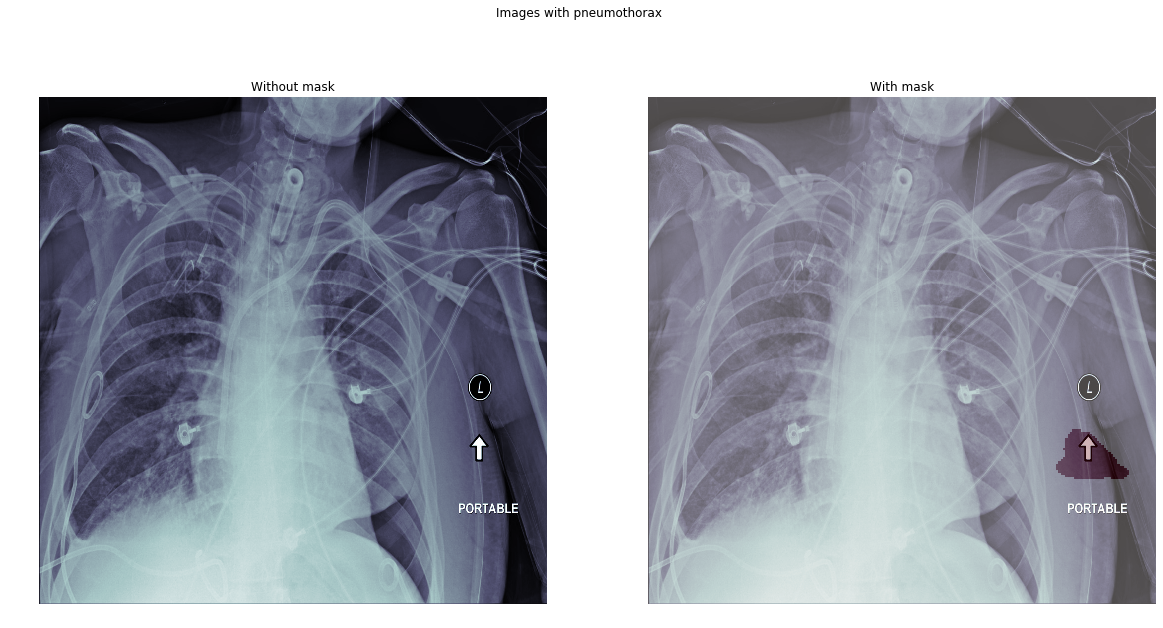

In [8]:
# plot some more predictions
pneumo, image, rle_mask, mask = get_image_and_pred(7, fns, submission)
plot_xray(image, rle_mask)

Woooow!!! That's a pity. My model was training for 8 hours to identify an arrow as a pneumothorax :( 

## Plot image grid

Now I would like to plot a grid of images with predicted masks:

In [9]:
images_pneumo = submission[submission['EncodedPixels'] != '-1']

In [10]:
# Plot several images with predicted pneumothorax
def plot_xray_grid(fns, submission):
    '''
    Function to plot several predictions
    INPUT:
        fns - files from the test dataset
        submission - submission file
    '''
    fig, axs = plt.subplots(2, 5, figsize=(20,8))
    idx = 0
    n = 0
    
    while n < 5:
        
        try:
            
            # get image and prediction
            pneumo, image, rle_mask, mask = get_image_and_pred(idx, fns, submission)

            if pneumo:

                #plot the original data
                axs[0, n].imshow(image, cmap='bone') 
                axs[0, n].axis('off')
                axs[0, n].set_title('Without mask')

                #plot image and add the mask
                axs[1, n].imshow(image, cmap='bone')
                axs[1, n].axis('off')  
                axs[1, n].imshow(rle_mask, alpha=0.3, cmap="Reds")    
                axs[1, n].set_title('With mask')

                n = n + 1
            
        except:
            pass
            
        idx = idx + 1
        
    # set suptitle
    plt.suptitle('Images with pneumothorax and masks', fontsize = 16)
    plt.show()

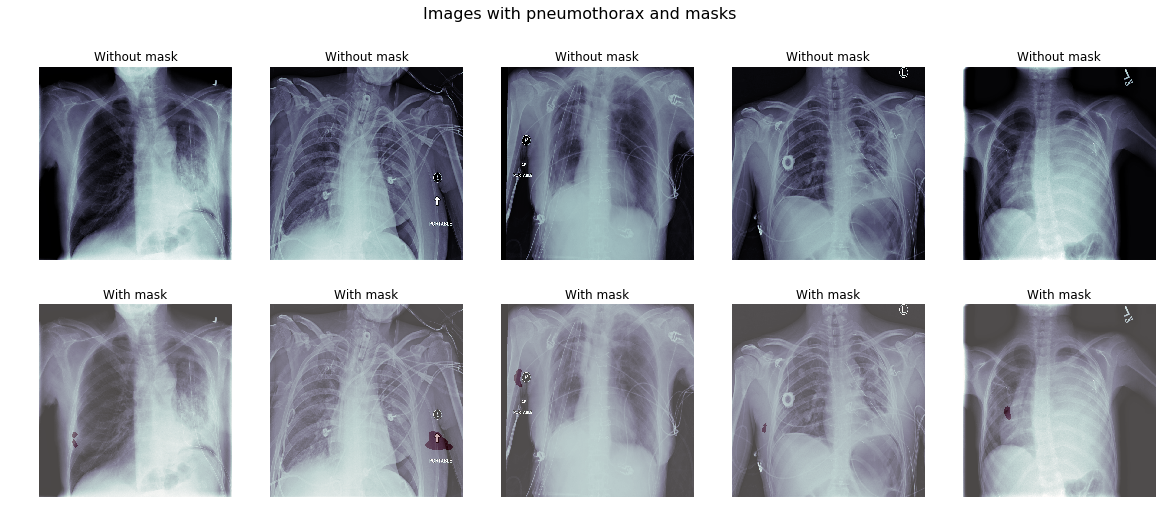

In [11]:
plot_xray_grid(fns, images_pneumo)

Well, I am very upset with the model. It seems that it just randomly highlights some areas. Sometimes it is not even a lung or chest area.

But at least I had fun looking at that :)